# **Initializing**

In [209]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import xgboost as xgb

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from xgboost import XGBRegressor

%matplotlib inline


In [210]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    """Target encoder.
    
    Replaces categorical column(s) with the mean target value for
    each category.

    """
    
    def __init__(self, cols=None):
        """Target encoder
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.  Default is to target 
            encode all categorical columns in the DataFrame.
        """
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        
        
    def fit(self, X, y):
        """Fit target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X 
                         if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                tmap[unique] = y[X[col]==unique].mean()
            self.maps[col] = tmap
            
        return self

        
    def transform(self, X, y=None):
        """Perform the target encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        Xo = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target
            Xo[col] = vals
        return Xo
            
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

In [211]:
!pip install category_encoders

# **Loading Data**

In [212]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [213]:
base_path = '/content/drive/My Drive/ML Challenge'
train_x_path = base_path + '/train_x.csv'
train_y_path = base_path + '/train_y.csv'
test_x_path = base_path + '/test_x.csv'
test_y_path = base_path + '/test_y.csv'

In [214]:
train_x = pd.read_csv(train_x_path)
train_y = pd.read_csv(train_y_path)
test_x = pd.read_csv(test_x_path)

# **Examining the Dataset**

In [215]:
train_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [216]:
train_y.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [217]:
train_x.installer.value_counts()

DWE                    17402
Government              1825
RWE                     1206
Commu                   1060
DANIDA                  1050
                       ...  
WINAM  CONSTRUCTION        1
Makundya                   1
Kwamdulu estate            1
SIMBA                      1
Winkyens                   1
Name: installer, Length: 2145, dtype: int64

In [218]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [219]:
train_x.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


# **Preparing the y Variable**

*Label Encoding the y variable*

In [220]:
train_y['status_group'].replace({'functional': 2, 'functional needs repair':1, 'non functional': 0}, inplace=True)

In [221]:
train_y.status_group.unique()

array([2, 0, 1])

*Removing the 'id' Column*

In [222]:
train_y = train_y.drop(['id'], axis=1)

# **Preparing the x Variable**

In [223]:
def drop_columns(x_train, x_test):
  drop_cols = ['id', 'extraction_type_group', 'extraction_type_class', 'num_private', 'region', 'recorded_by', 'payment', 'quality_group', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group']
  x_train = x_train.drop(drop_cols, axis=1)
  x_test = x_test.drop(drop_cols, axis=1)

  return x_train, x_test

***Function to Process Numeric Data***

In [224]:
def process_numerical(x_train, x_test):
  x_train['amount_tsh'] = (x_train['amount_tsh']-x_train['amount_tsh'].min())/(x_train['amount_tsh'].max()-x_train['amount_tsh'].min())
  x_test['amount_tsh'] = (x_test['amount_tsh']-x_test['amount_tsh'].min())/(x_test['amount_tsh'].max()-x_test['amount_tsh'].min())

  x_train['date_recorded'] = pd.to_datetime(x_train['date_recorded']).dt.year
  x_test['date_recorded'] = pd.to_datetime(x_test['date_recorded']).dt.year

  x_train['public_meeting'] = x_train['public_meeting'].astype('bool')
  x_test['public_meeting'] = x_test['public_meeting'].astype('bool')

  x_train['permit'] = x_train['permit'].astype('bool')
  x_test['permit'] = x_test['permit'].astype('bool')

  x_train['location'] = x_train['longitude']*x_train['latitude']
  x_test['location'] = x_test['longitude']*x_test['latitude']

  return x_train, x_test

***Function to Target Encode Columns***

In [225]:
def process_target(x_train, y_train, x_test):

  target_columns = ['wpt_name', 'subvillage', 'lga', 'ward', 'scheme_name']
  
  te = TargetEncoder()
  x_train[target_columns] = te.fit_transform(x_train[target_columns], y_train)
  x_test[target_columns] = te.transform(x_test[target_columns])

  return x_train, y_train, x_test

***Function to One-Hot Encode Columns***

In [226]:
def process_onehot(x):
  onehot_columns = ['basin', 'extraction_type', 'management_group', 'payment_type', 'waterpoint_type', 'funder', 'quantity', 'source', 'scheme_management', 'water_quality', 'management', 'installer']
  
  threshold = x.funder.value_counts()
  threshold_values = threshold[:5].index
  x['funder'] = x.funder.where(x.funder.isin(threshold_values), 'Other') 

  threshold = x.scheme_management.value_counts()
  threshold_values = threshold[:5].index
  x['scheme_management'] = x.scheme_management.where(x.scheme_management.isin(threshold_values), 'Other') 

  threshold = x.management.value_counts()
  threshold_values = threshold[:6].index
  x['management'] = x.management.where(x.management.isin(threshold_values), 'Other') 

  threshold = x.installer.value_counts()
  threshold_values = threshold[:6].index
  x['installer'] = x.installer.where(x.installer.isin(threshold_values), 'Other') 

  for column in onehot_columns:
    one_hot = pd.get_dummies(x[column], prefix=column)
    x = pd.concat([x, one_hot], axis=1)
  
  x = x.drop(onehot_columns, axis = 1)
  return x

***Function to Fill Missing Values***

In [227]:
from numpy import nan
from pandas import read_csv
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def fill_missing(x_train, y_train, x_test):
  imputer = SimpleImputer(missing_values=nan, strategy='median')
  imputer.fit(x_train, y_train)
  x = pd.DataFrame(imputer.fit_transform(x_train))
  x.columns = x_train.columns
  x.index = x_train.index

  xt = pd.DataFrame(imputer.transform(x_test))
  xt.columns = x_test.columns
  xt.index = x_test.index

  return x, xt

***Processing the x Variable***

In [228]:
train_x.amount_tsh

0        6000.0
1           0.0
2          25.0
3           0.0
4           0.0
          ...  
59395      10.0
59396    4700.0
59397       0.0
59398       0.0
59399       0.0
Name: amount_tsh, Length: 59400, dtype: float64

In [229]:
x1, xt1 = drop_columns(train_x, test_x)

In [230]:
x2, y_train, xt2 = process_target(x1, train_y, xt1)

In [231]:
train_size, test_size = train_x.shape[0], test_x.shape[0]
x = pd.concat([x2, xt2])

In [232]:
x = process_onehot(x)

In [233]:
x3, xt3 = x.iloc[:train_size,:], x.iloc[train_size:,:]

In [234]:
x4, xt4 = process_numerical(x3, xt3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [235]:
x5, xt5 = fill_missing(x4, y_train, xt4)

In [236]:
x5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Columns: 112 entries, amount_tsh to location
dtypes: float64(112)
memory usage: 51.2 MB


In [237]:
duplicated_columns_list = []
list_of_all_columns = list(x5.columns)
for column in list_of_all_columns:
    if list_of_all_columns.count(column) > 1 and not column in duplicated_columns_list:
        duplicated_columns_list.append(column)
duplicated_columns_list

[]

In [238]:
x_, x_t, y_, y_t = train_test_split(x5, train_y, test_size=0.33, random_state=42)

# **Testing the Performance of Machine Learning Models**

***Training XGBoost Model***

In [239]:
import matplotlib.pyplot as plt
from xgboost import plot_importance, XGBClassifier
from sklearn.metrics import f1_score
plt.rcParams["figure.figsize"] = (20,10)

xg_reg = xgb.XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=7, missing=None, n_estimators=100,
             n_jobs=1,num_class=3, nthread=None, objective='multi:softmax',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)
xg_reg.fit(x5, y_train)

predictions_xg = xg_reg.predict(x_t)
f1_score(y_t, predictions_xg, average=None)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.92490119, 0.53103761, 0.93096806])

***Training Logistic Regression Model***

In [240]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

lr = LogisticRegression(multi_class='multinomial')
lr.fit(x_, y_)

predictions_lr = lr.predict(x_t)
f1_score(y_t, predictions_lr, average=None)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([0.26765799, 0.        , 0.72115116])

***Training Random Forest Classifier Model***

In [241]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

rfc = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=6, min_samples_leaf=2, 
                               max_features='auto', min_impurity_decrease=0.1, min_impurity_split=None, 
                               bootstrap=True, warm_start=True)
rfc.fit(x_, y_)

predictions_rfc = rfc.predict(x_t)
f1_score(y_t, predictions_rfc, average=None)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


array([0.        , 0.        , 0.70703473])

***Training k Nearest Neighbours Model***

In [242]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_, y_)

predictions_knn = knn.predict(x_t)
f1_score(y_t, predictions_knn, average=None)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """


array([0.6921928 , 0.34808511, 0.77490508])

***Training Naive Bayes Model***

In [243]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler

scaler_m = MinMaxScaler()
scaler_m.fit(x_)
x_pos = scaler_m.transform(x_)
xt_pos = scaler_m.transform(x_t)

nb = CategoricalNB()
nb.fit(x_pos, y_)

predictions_nb = nb.predict(xt_pos)
f1_score(y_t, predictions_nb, average=None)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.79681008, 0.37880275, 0.87378092])

***Training Neural Network Model***

In [245]:
import tensorflow as tf

def plot_curve(epochs, hist, list_of_metrics):
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")
  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)
  plt.legend()

def create_model(learning_rate):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(units=1024, activation='relu'))
  model.add(tf.keras.layers.Dense(units=256, activation='relu'))
  model.add(tf.keras.layers.Dense(units=64, activation='relu'))
  model.add(tf.keras.layers.Dropout(rate=0.5))
  model.add(tf.keras.layers.Dense(units=3, activation='softmax'))      
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss="categorical_crossentropy",
                 metrics=["accuracy",
                       tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall()])
  return model    


def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=0.1):
  
  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, 
                      validation_split=validation_split)
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  return epochs, hist   

Epoch 1/100
8/8 [==============================] - 3s 231ms/step - loss: 2.0343 - accuracy: 0.5427 - precision_14: 0.5773 - recall_14: 0.4906 - val_loss: 0.5222 - val_accuracy: 0.8065 - val_precision_14: 0.8619 - val_recall_14: 0.7573
Epoch 2/100
8/8 [==============================] - 1s 183ms/step - loss: 0.5168 - accuracy: 0.8359 - precision_14: 0.8970 - recall_14: 0.7329 - val_loss: 0.3709 - val_accuracy: 0.8704 - val_precision_14: 0.9059 - val_recall_14: 0.8367
Epoch 3/100
8/8 [==============================] - 1s 181ms/step - loss: 0.3801 - accuracy: 0.8672 - precision_14: 0.9295 - recall_14: 0.8000 - val_loss: 0.3050 - val_accuracy: 0.8812 - val_precision_14: 0.9353 - val_recall_14: 0.8430
Epoch 4/100
8/8 [==============================] - 1s 182ms/step - loss: 0.3251 - accuracy: 0.8757 - precision_14: 0.9429 - recall_14: 0.8171 - val_loss: 0.2865 - val_accuracy: 0.8829 - val_precision_14: 0.9444 - val_recall_14: 0.8359
Epoch 5/100
8/8 [==============================] - 1s 185ms/

[0.5019248127937317,
 0.9028670787811279,
 0.9139605164527893,
 0.8930721282958984]

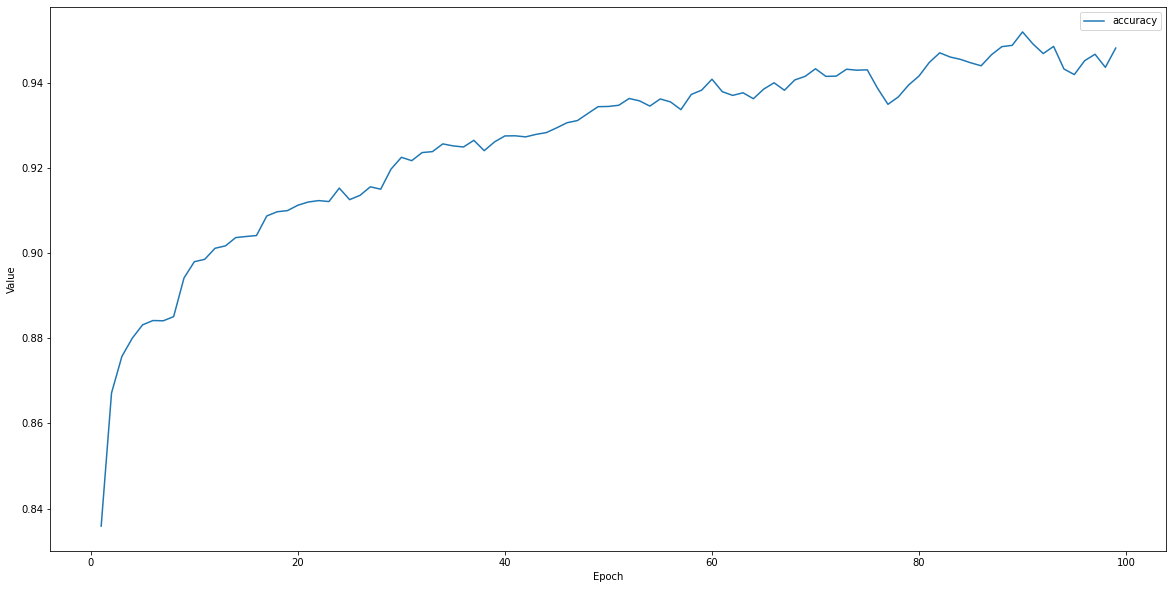

In [247]:
from sklearn.preprocessing import StandardScaler

scaler_s = StandardScaler()
scaler_s.fit(x_)
x_std = scaler_s.transform(x_)
xt_std = scaler_s.transform(x_t)

y_cat = pd.get_dummies(y_['status_group'])
yt_cat = pd.get_dummies(y_t['status_group'])

x_std = np.asarray(x_std).astype('float32')
model = create_model(learning_rate=0.01)
epochs, hist = train_model(model, x_std, y_cat, epochs=100, batch_size=5000, validation_split=0.1)
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot)
print("\n Evaluate the new model against the test set:")
model.evaluate(x=xt_std, y=yt_cat, batch_size=5000)

# **Plotting Feature Importance**

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

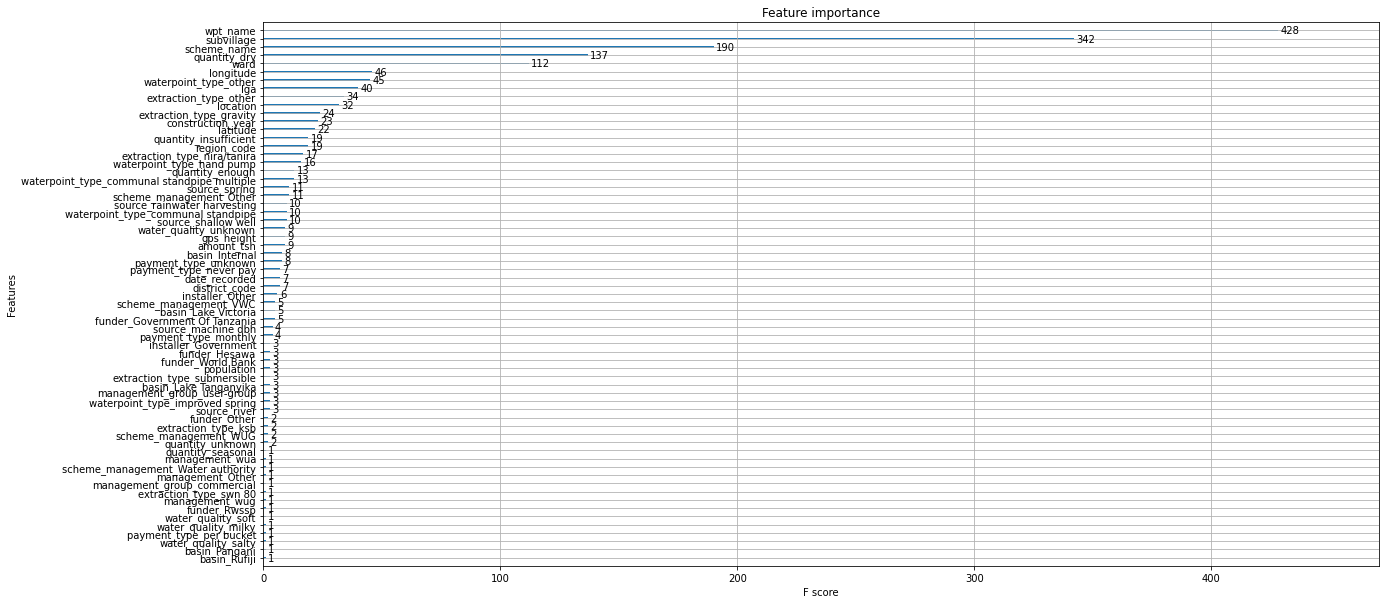

In [244]:
import matplotlib.pyplot as plt
from xgboost import plot_importance, XGBClassifier
plt.rcParams["figure.figsize"] = (20,10)

xg_reg = xgb.XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=7, missing=None, n_estimators=100,
             n_jobs=1,num_class=3, nthread=None, objective='multi:softmax',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)
xg_reg.fit(x_, y_)
cross_val_score(xg_reg, x4, y_train, cv=5, scoring='accuracy')

plot_importance(xg_reg)
plt.show()

# **Training the Final Model**

In [248]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

rfc = RandomForestClassifier(n_estimators=800, max_depth=None, min_samples_split=6, min_samples_leaf=2, 
                               max_features='auto', min_impurity_decrease=0.1, min_impurity_split=None, 
                               bootstrap=True, warm_start=True)
rfc.fit(x5, train_y)

predictions_rfc = rfc.predict(xt5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


# **Saving the Final Results**

In [249]:
y_test = pd.DataFrame(predictions_rfc)

In [250]:
y_test
y_test.replace({2:'functional', 1:'functional needs repair', 0:'non functional'}, inplace=True)

In [251]:
sub = pd.DataFrame()
sub['id'] = test_x['id']
sub['status_group'] = y_test

In [252]:
sub.to_csv(test_y_path,index=False)